In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install pyfeats


In [ ]:
nbdir = "/content/drive/MyDrive/DSCI 592 Group/"
%cd /content/drive/MyDrive/DSCI\ 592\ Group/

/content/drive/.shortcut-targets-by-id/1BhYZe1XofBTGFx4baMx5R_lUbTcscQK4/DSCI 592 Group


In [ ]:
import os
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import filters
from skimage import data
from skimage import exposure
from skimage.segmentation import slic,clear_border
from skimage.color import label2rgb, rgb2gray
from skimage.feature import graycomatrix, graycoprops
from skimage.morphology import remove_small_objects,remove_small_holes, binary_closing,binary_dilation,disk, binary_erosion
from skimage.filters import roberts
from skimage.measure import label,regionprops

from scipy import ndimage as ndi
from scipy.ndimage import interpolation as inter
from scipy.stats import zscore

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
import joblib
from google.colab import files

import pyfeats
import glob
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
import matplotlib.patches as mpatches

from sklearn.manifold import TSNE
from matplotlib import colors

In [ ]:
# Creates a new Data Frame with image filepaths, labels, and metadata info for all images within the specified directories
def get_image_metadata(image_path):
    with Image.open(image_path) as img:
        # Extract metadata
        info = {
            "jfif": img.info['jfif'],
            "jfif_version": img.info['jfif_version'],
            "jfif_unit": img.info['jfif_unit'],
            "jfif_density": img.info['jfif_density']
        }
        metadata = {
            "width": img.width,
            "height": img.height
            #"exif": img.getexif()
        }

    return info, metadata

def extract_metadata(benign_dir, Malignant_dir, Normal_dir):
    filepaths = []
    labels = []
    class_labels = ['Benign', 'Malignant', 'Normal']

    dir_lists = [benign_dir, Malignant_dir, Normal_dir]

    for i, dir_list in enumerate(dir_lists):
        for j in dir_list:
            flist = os.listdir(j)
            for f in flist:
                fpath = os.path.join(j, f)
                filepaths.append(fpath)
                labels.append(class_labels[i])

    Fseries = pd.Series(filepaths, name="filepaths")
    Lseries = pd.Series(labels, name="labels")
    Lung_data = pd.concat([Fseries, Lseries], axis=1)
    Lung_df = pd.DataFrame(Lung_data)
    pd.set_option('display.max_colwidth', None)
    jfif = []
    jfif_version = []
    dpi = []
    jfif_unit = []
    jfif_density = []
    width=[]
    height=[]
    #exif=[]

    for i in Lung_df["filepaths"]:
        info, metadata = get_image_metadata(i)
        jfif.append(info['jfif'])
        jfif_version.append(info['jfif_version'])
        jfif_unit.append(info['jfif_unit'])
        jfif_density.append(info['jfif_density'])
        width.append(metadata['width'])
        height.append(metadata['height'])
        #exif.append(metadata['exif'])

    jfif_series = pd.Series(jfif, name="info")
    jfif_version_series = pd.Series(jfif_version, name="jfif_version")
    jfif_unit_series = pd.Series(jfif_unit, name="jfif_unit")
    jfif_density_series = pd.Series(jfif_density, name="jfif_density")
    width_series = pd.Series(width, name="width")
    height_series = pd.Series(height, name="height")
    #exif_series = pd.Series(exif, name="exif")

    Lung_df = pd.concat([Lung_df, jfif_series, jfif_version_series, jfif_unit_series, jfif_density_series, width_series, height_series], axis=1)

    return Lung_df

# Function to compute statistics for a single image
def compute_image_stats(image):

    image_array = np.array(image)

    stats = {
        #'Image ID': os.path.basename(image),
        'Mean Pixel Value': np.nanmean(image_array),
        'Std Dev Pixel Value': np.nanstd(image_array),
        'Min Pixel Value': np.nanmin(image_array),
        'Max Pixel Value': np.nanmax(image_array),
        '25th Percentile': np.nanpercentile(image_array, 25),
        '50th Percentile (Median)': np.nanpercentile(image_array, 50),
        '75th Percentile': np.nanpercentile(image_array, 75)
    }

    return stats

# Get all image paths
def get_image_paths(dirs, file_extension):
    image_paths = []
    for dir in dirs:
        image_paths.extend(glob.glob(os.path.join(dir, f'*.{file_extension}')))

    return image_paths

def display_stats(df, label):
    # Display the statistics in table format
    print(f"{label} Image Statistics")
    stats_table = df.describe().T  # Transpose for better readability
    print(stats_table)

    # Convert the table to LaTeX
    latex_table = stats_table.to_latex()
    print("\nLaTeX Table:")
    print(latex_table)

    # Plot the statistics
    stats_table[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].plot(kind='bar', figsize=(10, 6))
    plt.title(f"{label} Image Statistics")
    plt.ylabel("Pixel Value")
    plt.xticks(rotation=45)
    plt.show()

def determine_score(arr, angle):
    data = inter.rotate(arr, angle, reshape=False, order=0)
    histogram = np.sum(data, axis=1, dtype=float)
    score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)

    return histogram, score

def correct_skew(image, delta=1, limit=5):
    #gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)
    best_angle = angles[scores.index(max(scores))]
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv.warpAffine(image, M, (w, h), flags=cv.INTER_CUBIC, \
            borderMode=cv.BORDER_REPLICATE)

    return best_angle, corrected

def bit_plane_slice(image):
    bit_planes = []
    for i in range(8):
        mask = 2 ** i
        bit_plane = np.bitwise_and(image, mask)
        bit_planes.append(bit_plane)

    return bit_planes

def reconstruct_image(bit_planes):
    reconstructed_image = np.zeros_like(bit_planes[0])
    for i in range(6):
        reconstructed_image = np.bitwise_or(reconstructed_image, bit_planes[-i])

    return reconstructed_image

def isolate_lung_area(image):
    label_image = label(image)
    regions = regionprops(label_image)
    image_height = image.shape[0]

    filtered_regions = [region for region in regions if region.area >= 600 and region.centroid[0] <= image_height * 0.75]
    regions = sorted(filtered_regions, key=lambda x: x.area, reverse=True)

    if len(regions) > 3:
      top_n_regions = sorted(regions, key=lambda x: x.centroid[0])
      top_n_highest_regions = top_n_regions[:-2]
    elif len(regions) > 2:
      top_n_regions = sorted(regions, key=lambda x: x.centroid[0])
      top_n_highest_regions = top_n_regions[:-1]
    else:
      top_n_highest_regions = regions

    mask = np.zeros_like(label_image, dtype=bool)
    for region in top_n_highest_regions:
        for coordinates in region.coords:
          mask[coordinates[0], coordinates[1]] = 1

    return mask

# Function to predict class label for validation data
def predict_image(img):
    img_flat = img.flatten().reshape(1, -1)  # Flatten and reshape image to match the input format expected by the model
    # Load the trained RandomForestClassifier model
    #best_model = joblib.load('best_RF_model.pkl')
    # Predict class label for the image
    pred_label = best_model.predict(img_flat)[0]  # Assuming you're only interested in the prediction for the first image in the batch
    # Return the predicted label
    return pred_label

def pipeline(image):
  camera =  cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  angle, corrected = correct_skew(camera)
  bit_planes = bit_plane_slice(corrected)
  bit_plane_reconstructed = reconstruct_image(bit_planes)
  gauss = cv.GaussianBlur(bit_plane_reconstructed, (5, 5), 5)
  thresh_val = filters.threshold_otsu(gauss)
  thresh = gauss<thresh_val

  cleared = clear_border(thresh)

  height = cleared.shape[0]
  bed_cutoff = int(height * 0.85)
  cleared[bed_cutoff:, :] = False

  cleared = isolate_lung_area(cleared)
  cleared = binary_dilation(cleared, footprint=disk(8))
  cleared = remove_small_objects(cleared,min_size=650)
  cleared = remove_small_holes(cleared,area_threshold=900)
  selem = disk(3, dtype=bool)
  cleared = binary_closing(cleared,disk(8))
  cleared = ndi.binary_fill_holes(cleared)
  cleared = binary_erosion(cleared, selem)

  cleared = binary_closing(cleared,disk(12))

  result1 = gauss.copy()
  result1[cleared == 0] = 0
  #transform 0s to Nans
  result1 = np.where(result1 == 0, np.nan, result1)
  result1[cleared != 0] = gauss[cleared != 0]

  #zscore the dataset, ignoring mask regions
  result1[cleared != 0] = (result1[cleared != 0]-np.mean(result1[cleared != 0]))/np.std(result1[cleared != 0])

  return result1


In [ ]:
mapping={"Normal":"Non-malignant","Benign":"Non-malignant","Malignant":"Malignant"}
colors = {'Non-malignant':'#D3D3D3', 'Malignant':'#DA2005'}


In [ ]:
benign_dir_UNET = ['./data/The IQ-OTHNCCD lung cancer dataset/Bengin UNET Segmented']
Malignant_dir_UNET = ['./data/The IQ-OTHNCCD lung cancer dataset/Malignant UNET Segmented']
Normal_dir_UNET = ['./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented']

In [ ]:
#This code chunk takes ~5 mins
Lung_df_UNET = extract_metadata(benign_dir_UNET, Malignant_dir_UNET, Normal_dir_UNET)
Lung_df_UNET.head()

,filepaths,labels,info,jfif_version,jfif_unit,jfif_density,width,height
0,./data/The IQ-OTHNCCD lung cancer dataset/Bengin UNET Segmented/Bengin case (96).jpg,Benign,257,"(1, 1)",0,"(1, 1)",512,512
1,./data/The IQ-OTHNCCD lung cancer dataset/Bengin UNET Segmented/Bengin case (97).jpg,Benign,257,"(1, 1)",0,"(1, 1)",512,512
2,./data/The IQ-OTHNCCD lung cancer dataset/Bengin UNET Segmented/Bengin case (87).jpg,Benign,257,"(1, 1)",0,"(1, 1)",512,512
3,./data/The IQ-OTHNCCD lung cancer dataset/Bengin UNET Segmented/Bengin case (79).jpg,Benign,257,"(1, 1)",0,"(1, 1)",512,512
4,./data/The IQ-OTHNCCD lung cancer dataset/Bengin UNET Segmented/Bengin case (99).jpg,Benign,257,"(1, 1)",0,"(1, 1)",512,512


In [ ]:
Lung_df_UNET_filtered = Lung_df_UNET[Lung_df_UNET["width"]==512]
Lung_df_UNET_filtered = Lung_df_UNET_filtered[Lung_df_UNET_filtered["height"]==512]
print(f"# scans passed QC: {Lung_df_UNET_filtered.shape[0]}")

# scans passed QC: 1102


In [ ]:
Lung_df_UNET_filtered["labels_2"]= Lung_df_UNET_filtered["labels"].map(mapping)

In [ ]:
%%capture
#process images and add to image_array
#this chunk take ~7min
image_array_UNET=[]
for i in Lung_df_UNET_filtered["filepaths"]:
  img = cv.imread(i,cv.IMREAD_GRAYSCALE)
  img = np.where(img == 0, np.nan, img)
  #zscore the dataset, ignoring mask regions
  img[img != 0] = (img[img != np.nan]-np.nanmean(img[img != np.nan]))/np.nanstd(img[img != np.nan])
  image_array_UNET.append(img)

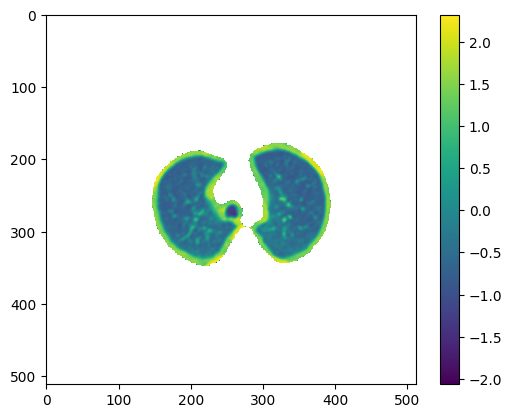

In [ ]:
plt.imshow(image_array_UNET[0])
plt.colorbar(plt.imshow(image_array_UNET[0]))


In [ ]:
image_stats_UNET = [compute_image_stats(image_path) for image_path in image_array_UNET]
image_stats_UNET_df = pd.DataFrame(image_stats_UNET)

In [ ]:
Lung_df_UNET_filtered_2 = pd.concat([Lung_df_UNET_filtered.reset_index(drop=True), image_stats_UNET_df.reset_index(drop=True)],axis=1)
print(len(Lung_df_UNET_filtered_2))
Lung_df_UNET_filtered_2.tail()

1102


,filepaths,labels,info,jfif_version,jfif_unit,jfif_density,width,height,labels_2,Mean Pixel Value,Std Dev Pixel Value,Min Pixel Value,Max Pixel Value,25th Percentile,50th Percentile (Median),75th Percentile
1097,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (100) (1).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-2.870199e-17,1.0,-1.649886,2.054901,-0.836640,-0.445077,1.211535
1098,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (100).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-2.870199e-17,1.0,-1.649886,2.054901,-0.836640,-0.445077,1.211535
1099,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (105).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,2.563164e-17,1.0,-1.628504,2.126206,-0.780667,-0.614127,1.232948
1100,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (109).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-9.330902e-17,1.0,-1.623906,2.044455,-0.787520,-0.655459,1.193395
1101,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (106).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-9.775061e-17,1.0,-1.669812,2.079169,-0.816385,-0.496350,1.225742


In [ ]:
%%capture
#compute feature arrays for GLCM texture analysis
data_UNET=[]
for img in image_array_UNET:
    glcm = pyfeats.glcm_features(img,ignore_zeros=True)[0]
    data_UNET.append(glcm)

labels = ["GLCM_ASM", "GLCM_Contrast", "GLCM_Correlation","GLCM_SumOfSquaresVariance", "GLCM_InverseDifferenceMoment","GLCM_SumAverage", "GLCM_SumVariance", "GLCM_SumEntropy","GLCM_Entropy", "GLCM_DifferenceVariance","GLCM_DifferenceEntropy", "GLCM_Information1","GLCM_Information2", "GLCM_MaximalCorrelationCoefficient"]
temp_UNET = pd.DataFrame(data_UNET,columns=labels)
temp_UNET.head()

In [ ]:
#Concatenate feature attributes with metadata table
master_table_UNET = pd.concat([Lung_df_UNET_filtered_2.reset_index(drop=True), temp_UNET.reset_index(drop=True)], axis=1)
print(len(master_table_UNET))
master_table_UNET.tail()
#master_table.to_csv("normalized_metadata_w_features_2024_08_20.csv")
#from google.colab import files
#files.download("normalized_metadata_w_features_2024_08_20.csv")

1102


,filepaths,labels,info,jfif_version,jfif_unit,jfif_density,width,height,labels_2,Mean Pixel Value,...,GLCM_InverseDifferenceMoment,GLCM_SumAverage,GLCM_SumVariance,GLCM_SumEntropy,GLCM_Entropy,GLCM_DifferenceVariance,GLCM_DifferenceEntropy,GLCM_Information1,GLCM_Information2,GLCM_MaximalCorrelationCoefficient
1097,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (100) (1).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-2.870199e-17,...,0.999874,10.037706,4016.417123,0.121518,0.121769,0.003889,0.003344,-0.983459,0.456892,0.799779
1098,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (100).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-2.870199e-17,...,0.999874,10.037706,4016.417123,0.121518,0.121769,0.003889,0.003344,-0.983459,0.456892,0.799779
1099,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (105).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,2.563164e-17,...,0.999337,13.649079,5771.832761,0.176454,0.177719,0.003881,0.014319,-0.945751,0.520820,0.757379
1100,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (109).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-9.330902e-17,...,0.999844,15.642693,6735.461294,0.181354,0.181589,0.003889,0.003368,-0.987242,0.544979,0.750633
1101,./data/The IQ-OTHNCCD lung cancer dataset/Normal UNET Segmented/Normal case (106).jpg,Normal,257,"(1, 1)",0,"(1, 1)",512,512,Non-malignant,-9.775061e-17,...,0.999669,11.161648,4566.236333,0.141069,0.141731,0.003886,0.007926,-0.964283,0.479977,0.774222


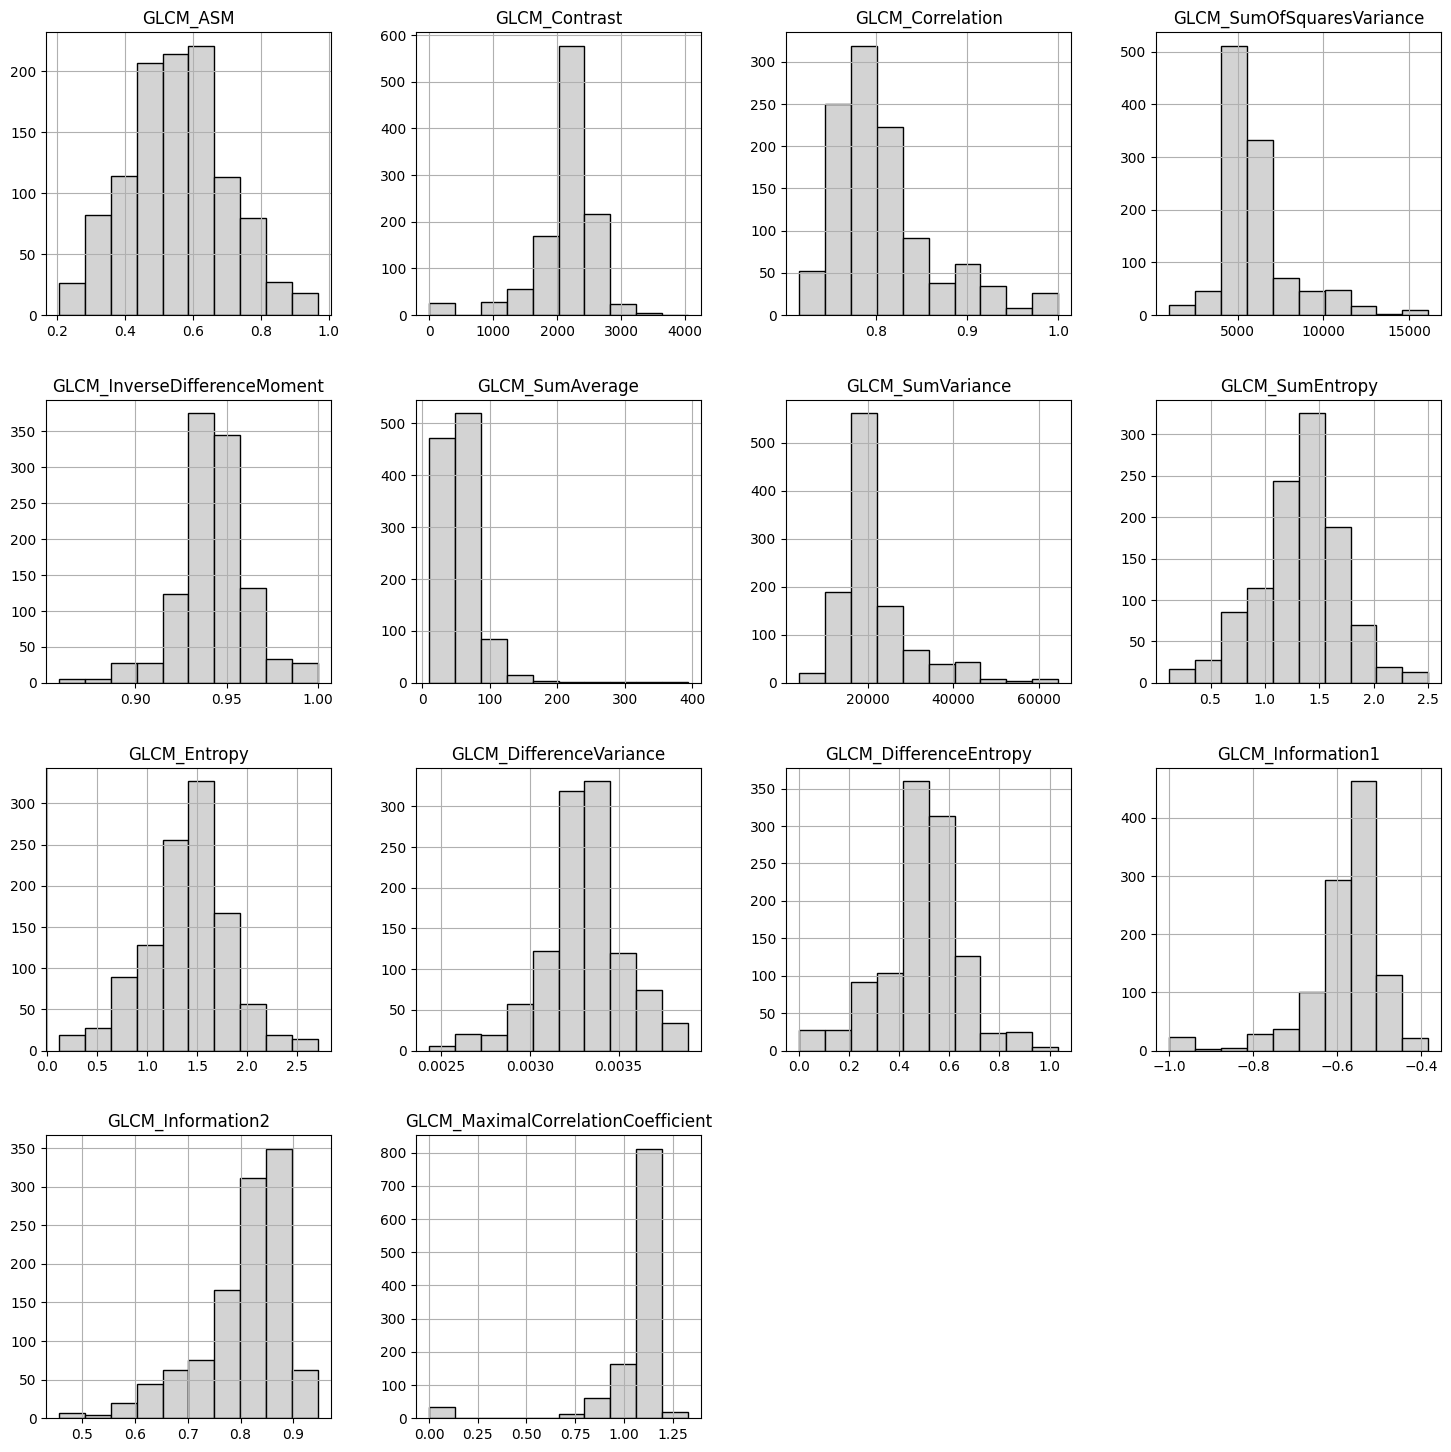

In [ ]:
master_table_UNET.drop(['filepaths', 'labels', 'info', 'jfif_version', 'jfif_unit',"Mean Pixel Value","Std Dev Pixel Value","Min Pixel Value","Max Pixel Value",
       'jfif_density','width', 'height',"25th Percentile","50th Percentile (Median)","75th Percentile"],axis=1).hist(bins=10, figsize=(18,18),edgecolor="black",color="#D3D3D3")
plt.show()

In [ ]:
X_1_UNET = temp_UNET
Y_1_UNET = Lung_df_UNET_filtered_2["labels_2"]

X_1_UNET_train, X_1_UNET_test, Y_1_UNET_train, Y_1_UNET_test = train_test_split(X_1_UNET, Y_1_UNET,test_size=.3,stratify = Y_1_UNET, random_state = 70000)

In [ ]:
numeric_features = X_1_UNET_train.columns
numeric_transformer = Pipeline(
    steps=[
        ('scaler',preprocessing.StandardScaler())
    ]
)

preprocessor_all = ColumnTransformer(
    transformers=[
        ('num',numeric_transformer,numeric_features)
    ]
)

L1 = Pipeline(
    steps=[('preprocessor',preprocessor_all),('classifier',LogisticRegression(penalty='l1',solver="saga",C=10))]
)

In [ ]:
parameters = [{'C': [.01, .1, 1, 10, 100, 1000]}]
lasso_grid = Pipeline(
    steps=[('preprocessor', preprocessor_all),
           ('classifier', GridSearchCV(estimator=LogisticRegression(penalty='l1', solver="saga",max_iter=10000,tol=.001),
                                      param_grid=parameters))])

Text(0, 0.5, 'Mean test score')

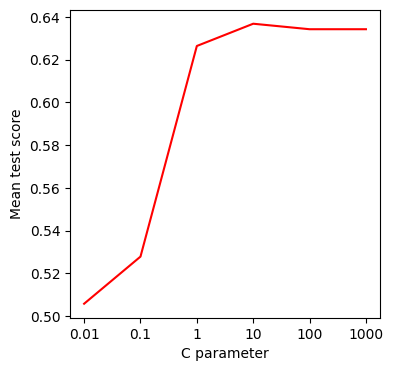

In [ ]:
lasso_grid.fit(X_1_UNET_train, Y_1_UNET_train)
plt.figure(figsize=[4,4])
sns.lineplot(lasso_grid.named_steps['classifier'].cv_results_['mean_test_score'],color='red')
plt.xticks([0, 1, 2,3,4,5], [.01, .1, 1, 10, 100, 1000])
plt.xlabel("C parameter")
plt.ylabel("Mean test score")

In [ ]:
L1.fit(X_1_UNET_train,Y_1_UNET_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['GLCM_ASM', 'GLCM_Contrast', 'GLCM_Correlation',
       'GLCM_SumOfSquaresVariance', 'GLCM_InverseDifferenceMoment',
       'GLCM_SumAverage', 'GLCM_SumVariance', 'GLCM_SumEntropy',
       'GLCM_Entropy', 'GLCM_DifferenceVariance', 'GLCM_DifferenceEntropy',
       'GLCM_Information1', 'GLCM_Information2',
       'GLCM_MaximalCorrelationCoefficient'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(C=10, penalty='l1', solver='saga'))])

Classification Report:
               precision    recall  f1-score   support

    Malignant       0.62      0.66      0.64       169
Non-malignant       0.62      0.59      0.60       162

     accuracy                           0.62       331
    macro avg       0.62      0.62      0.62       331
 weighted avg       0.62      0.62      0.62       331

Accuracy of the Model: 62.2%


([<matplotlib.axis.YTick at 0x7eb2b3670df0>,
 [Text(0, 0, 'Malignant'), Text(0, 1, 'Non-Malignant')])

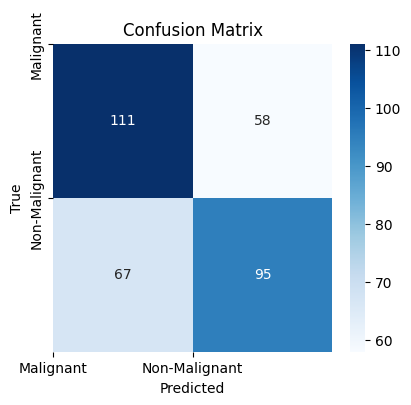

In [ ]:
# Output Classification report on Testing Data and Confusion Matrix
# Generate classification report
print("Classification Report:")
print(classification_report(Y_1_UNET_test, L1.predict(X_1_UNET_test)))
# Define class labels
class_labels = ["Malignant", "Non-Malignant"]
# Generate confusion matrix
conf_matrix = confusion_matrix(Y_1_UNET_test, L1.predict(X_1_UNET_test))
# Print accuracy
print("Accuracy of the Model: {:.1f}%".format(accuracy_score(Y_1_UNET_test, L1.predict(X_1_UNET_test)) * 100))
# Plot confusion matrix
plt.figure(figsize=(4.5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)
#plt.savefig('confusion.jpg')
#files.download('confusion.jpg')

In [ ]:
#Set Directories
normal_dir = ['./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented']
Malignant_dir = ['./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma UNET Segmented']
Malignant_dir2 = ['./data/DLCTLungDetectNet/Unrefined Data/squamous.cell.carcinoma UNET Segmented']
Malignant_dir3 = ['./data/DLCTLungDetectNet/Unrefined Data/adenocarcinoma UNET Segmented']

In [ ]:
#Extract metadata from validation dataset
dir_lists = [Malignant_dir,Malignant_dir2,Malignant_dir3, normal_dir]
filepaths=[]
labels=[]
class_labels = ["Malignant","Malignant",'Malignant','Normal']
for i, dir_list in enumerate(dir_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

height=[]
width=[]
for i in filepaths:
        tmp = Image.open(i)
        width.append(tmp.width)
        height.append(tmp.height)

Lung_df_UNET_validation = pd.DataFrame({'filepath': filepaths, 'label': labels,"height":height,"width":width})
Lung_df_UNET_validation.head()

,filepath,label,height,width
0,./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma UNET Segmented/large.cell.carcinoma160.png,Malignant,512,512
1,./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma UNET Segmented/large.cell.carcinoma131.png,Malignant,512,512
2,./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma UNET Segmented/large.cell.carcinoma53.png,Malignant,512,512
3,./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma UNET Segmented/large.cell.carcinoma24.png,Malignant,512,512
4,./data/DLCTLungDetectNet/Unrefined Data/large.cell.carcinoma UNET Segmented/large.cell.carcinoma5.png,Malignant,512,512


In [ ]:
%%capture
#process images and add to image_array
#this chunk take ~7min
image_array_UNET_validation=[]
for i in Lung_df_UNET_validation["filepath"]:
  a = cv.imread(i)
  a = np.where(a == 0, np.nan, a)
  #zscore the dataset, ignoring mask regions
  a[a != np.nan] = (a[a != np.nan]-np.nanmean(a[a != np.nan]))/np.nanstd(a[a != np.nan])
  image_array_UNET_validation.append(a)


In [ ]:
empty=[]
for i in image_array_UNET_validation:
  if np.isnan(i).all():
    empty.append("Empty")
  else:
    empty.append("Not Empty")

Lung_df_UNET_validation["Empty"] = empty
pd.value_counts(Lung_df_UNET_validation["Empty"])

<ipython-input-60-86eaff9116f6>:9: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(Lung_df_UNET_validation["Empty"])


,count
Empty,
Not Empty,977
Empty,23


In [ ]:
image_array_UNET_clean = [img for img, is_empty in zip(image_array_UNET_validation, Lung_df_UNET_validation["Empty"]=="Not Empty") if is_empty]
Lung_df_UNET_filtered_validation = Lung_df_UNET_validation[Lung_df_UNET_validation["Empty"]=="Not Empty"]

In [ ]:
image_stats_UNET_validation = [compute_image_stats(image_path) for image_path in image_array_UNET_clean]
image_stats_UNET_df_validation = pd.DataFrame(image_stats_UNET_validation)

In [ ]:
Lung_df_UNET_filtered_2_validation = pd.concat([Lung_df_UNET_filtered_validation.reset_index(drop=True), image_stats_UNET_df_validation.reset_index(drop=True)],axis=1)
print(len(Lung_df_UNET_filtered_2_validation))
Lung_df_UNET_filtered_2_validation.tail()

977


,filepath,label,height,width,Empty,Mean Pixel Value,Std Dev Pixel Value,Min Pixel Value,Max Pixel Value,25th Percentile,50th Percentile (Median),75th Percentile
972,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal80.png,Normal,512,512,Not Empty,1.427013e-16,1.0,-4.724889,1.831278,-0.630742,-0.105142,0.669426
973,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal82.png,Normal,512,512,Not Empty,1.427013e-16,1.0,-4.724889,1.831278,-0.630742,-0.105142,0.669426
974,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal90.png,Normal,512,512,Not Empty,1.446303e-16,1.0,-0.706634,4.048095,-0.483407,-0.394117,-0.215535
975,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal84.png,Normal,512,512,Not Empty,1.427013e-16,1.0,-4.724889,1.831278,-0.630742,-0.105142,0.669426
976,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal96.png,Normal,512,512,Not Empty,-3.558535e-17,1.0,-0.705584,4.064948,-0.481615,-0.392028,-0.212853


In [ ]:
%%capture
#compute feature arrays for GLCM texture analysis
data2_UNET=[]
for img in image_array_UNET_clean:
    glcm = pyfeats.glcm_features(img,ignore_zeros=True)[0]
    data2_UNET.append(glcm)

labels = ["GLCM_ASM", "GLCM_Contrast", "GLCM_Correlation","GLCM_SumOfSquaresVariance", "GLCM_InverseDifferenceMoment","GLCM_SumAverage", "GLCM_SumVariance", "GLCM_SumEntropy","GLCM_Entropy", "GLCM_DifferenceVariance","GLCM_DifferenceEntropy", "GLCM_Information1","GLCM_Information2", "GLCM_MaximalCorrelationCoefficient"]
temp2_UNET = pd.DataFrame(data2_UNET,columns=labels)
temp2_UNET.head()

In [ ]:
#Concatenate feature attributes with metadata table
master_table_UNET_validation = pd.concat([Lung_df_UNET_filtered_2_validation.reset_index(drop=True), temp2_UNET.reset_index(drop=True)], axis=1)
print(len(master_table_UNET_validation))
master_table_UNET_validation.tail()
#Lung_df.to_csv("validation_normalized_metadata_w_features_2024_08_20.csv")
#from google.colab import files
#files.download("validation_normalized_metadata_w_features_2024_08_20.csv")

977


,filepath,label,height,width,Empty,Mean Pixel Value,Std Dev Pixel Value,Min Pixel Value,Max Pixel Value,25th Percentile,...,GLCM_InverseDifferenceMoment,GLCM_SumAverage,GLCM_SumVariance,GLCM_SumEntropy,GLCM_Entropy,GLCM_DifferenceVariance,GLCM_DifferenceEntropy,GLCM_Information1,GLCM_Information2,GLCM_MaximalCorrelationCoefficient
972,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal80.png,Normal,512,512,Not Empty,1.427013e-16,1.0,-4.724889,1.831278,-0.630742,...,0.982483,133.939460,49413.165249,1.264765,1.303732,0.003634,0.217408,-0.897470,0.938013,1.355677
973,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal82.png,Normal,512,512,Not Empty,1.427013e-16,1.0,-4.724889,1.831278,-0.630742,...,0.982483,133.939460,49413.165249,1.264765,1.303732,0.003634,0.217408,-0.897470,0.938013,1.355677
974,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal90.png,Normal,512,512,Not Empty,1.446303e-16,1.0,-0.706634,4.048095,-0.483407,...,0.910168,3.877048,1.718826,2.018199,2.201798,0.103098,0.647958,-0.512619,0.869771,0.982923
975,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal84.png,Normal,512,512,Not Empty,1.427013e-16,1.0,-4.724889,1.831278,-0.630742,...,0.982483,133.939460,49413.165249,1.264765,1.303732,0.003634,0.217408,-0.897470,0.938013,1.355677
976,./data/DLCTLungDetectNet/Unrefined Data/normal UNET Segmented/normal96.png,Normal,512,512,Not Empty,-3.558535e-17,1.0,-0.705584,4.064948,-0.481615,...,0.909405,3.907800,1.707487,2.017880,2.203591,0.102748,0.651353,-0.508859,0.867622,0.982645


In [ ]:
%%capture
val_UNET = master_table_UNET_validation
val_UNET["label"][val_UNET["label"]=="Malignant"]="Malignant"
val_UNET["label"][val_UNET["label"]=="Normal"]="Non-malignant"

In [ ]:
val_UNET_Y = val_UNET["label"]
val_UNET_X =  val_UNET.drop(columns=["Mean Pixel Value","Std Dev Pixel Value","25th Percentile","50th Percentile (Median)","75th Percentile",'filepath', 'label', 'width', 'height','Max Pixel Value', 'Min Pixel Value'])

Classification Report:
               precision    recall  f1-score   support

    Malignant       0.77      0.61      0.68       784
Non-malignant       0.15      0.28      0.19       193

     accuracy                           0.54       977
    macro avg       0.46      0.44      0.44       977
 weighted avg       0.65      0.54      0.59       977

Accuracy of the Model: 54.4%


([<matplotlib.axis.YTick at 0x7eb2bc004dc0>,
 [Text(0, 0, 'Malignant'), Text(0, 1, 'Non-malignant')])

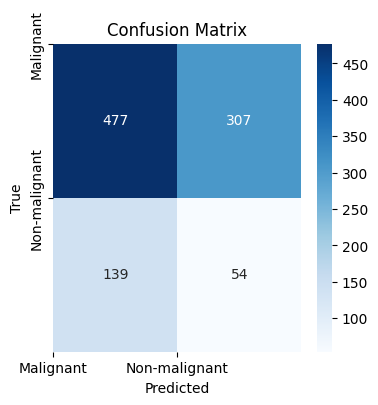

In [ ]:
print("Classification Report:")
print(classification_report(val_UNET_Y, L1.predict(val_UNET_X)))
# Define class labels
class_labels = ["Malignant", "Non-malignant"]
# Generate confusion matrix
conf_matrix = confusion_matrix(val_UNET_Y, L1.predict(val_UNET_X))
# Print accuracy
print("Accuracy of the Model: {:.1f}%".format(accuracy_score(val_UNET_Y, L1.predict(val_UNET_X)) * 100))
# Plot confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(class_labels)), labels=class_labels)
plt.yticks(ticks=np.arange(len(class_labels)), labels=class_labels)